In [1]:
## import useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

In [176]:
# read from the data csv
df = pd.read_csv('electrical_stability.csv') 
df # whenever stab >0, stabf = unstable and stab <0, stabf = stable

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,0.023892,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,-0.025803,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,-0.031810,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,0.037789,unstable


In [177]:
# Checking for null values in the dataframe
df.rename(columns={"stabf" : "stability"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tau1       10000 non-null  float64
 1   tau2       10000 non-null  float64
 2   tau3       10000 non-null  float64
 3   tau4       10000 non-null  float64
 4   p1         10000 non-null  float64
 5   p2         10000 non-null  float64
 6   p3         10000 non-null  float64
 7   p4         10000 non-null  float64
 8   g1         10000 non-null  float64
 9   g2         10000 non-null  float64
 10  g3         10000 non-null  float64
 11  g4         10000 non-null  float64
 12  stab       10000 non-null  float64
 13  stability  10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [178]:
# Removing outliers from the dataset
from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

In [179]:
# Dummy values for the 'stabf' column: stabf has two outputs given by 1. stable 2. unstable
#dummy_columns = df.select_dtypes(include='object').columns # columns to dummify: stabf is the only categorical value
#df_dummies = pd.get_dummies(df, prefix=dummy_columns)
#df_dummies

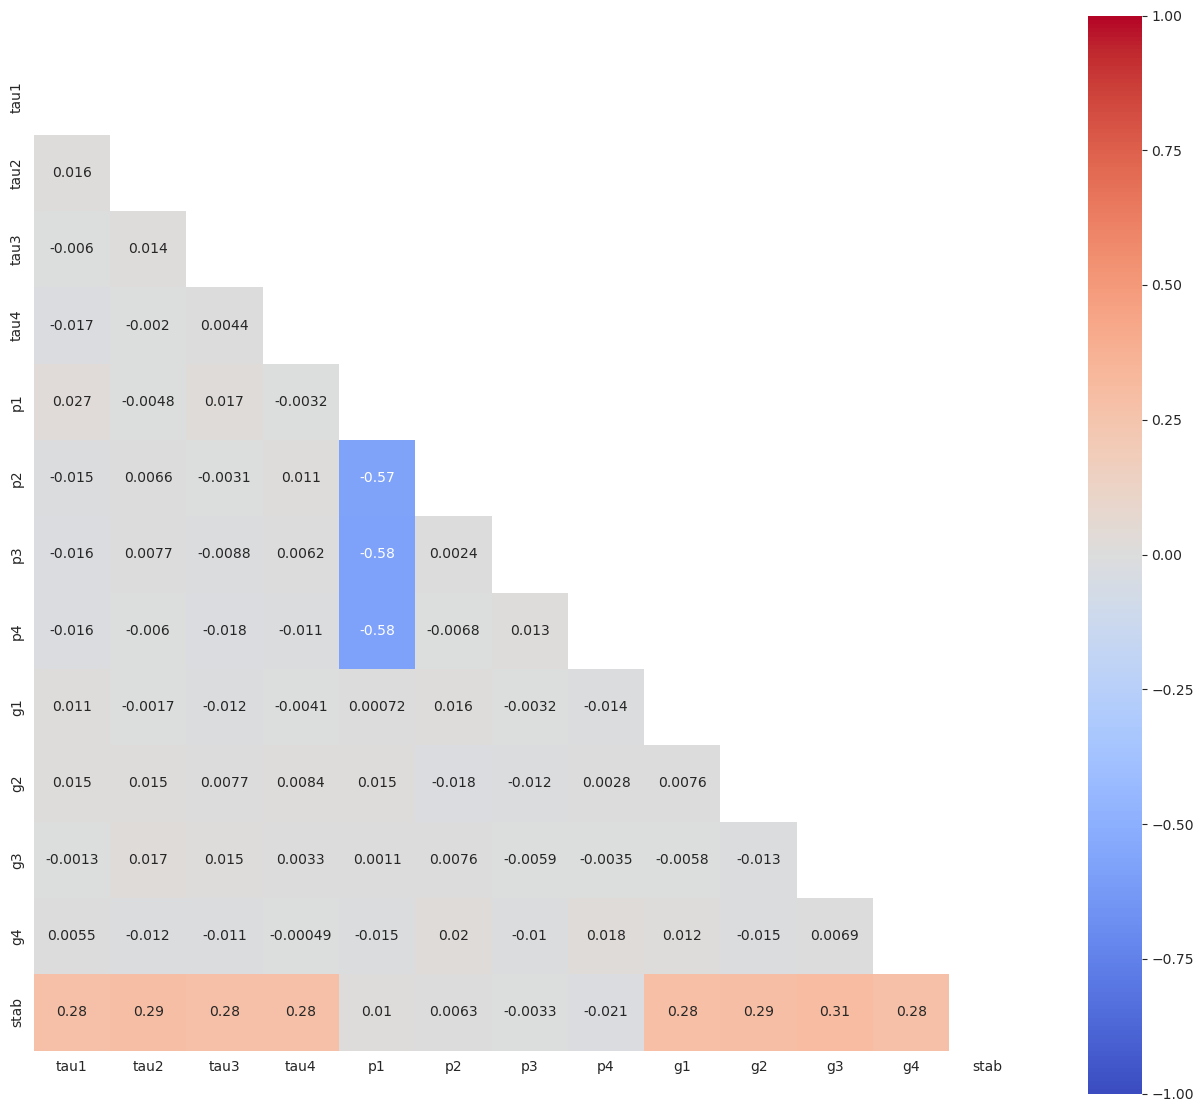

In [180]:
# correlation heat map: the first insight into the data
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

[Text(0, 0.5, 'Average time constant'), Text(0.5, 0, 'Stability')]

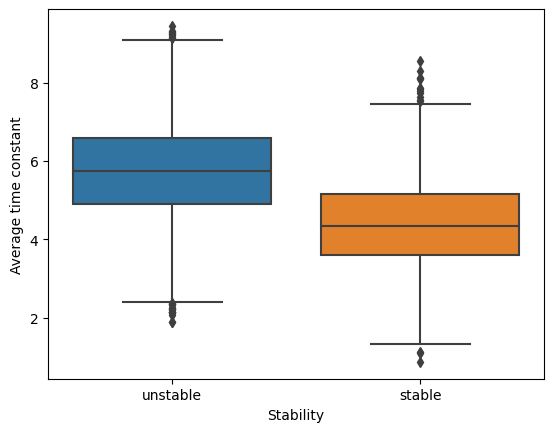

In [181]:
# Just for showing a plot between average tau and stability
df["tau_avg"] = pd.DataFrame(0.25*(df["tau1"] + df["tau2"] + df["tau3"] + df["tau4"]))
graph = sns.boxplot(y=df['tau_avg'], x=df["stability"])
graph.set(ylabel="Average time constant", xlabel = "Stability")
#graph.axvline(4.5, c='g',  linestyle="dashed")
#graph.axvline(6, c='r',  linestyle="dashed")

In [ ]:
df.iloc[0:10].plot(y=['p1', 'p2', 'p3', 'p4'])

In [182]:
## Prediction and modeling

# test-train split
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

X = df.drop('stab', axis=1).drop('stability', axis=1).drop('tau_avg', axis=1) # all the variables, except 'stab' and 'stabf' and tau_avg
y = df.stab # 'stab' is our numerical output variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE) # test-train split
X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)
X_train

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
3525,6.779586,9.645920,6.081267,2.938359,2.696722,-0.560577,-0.744007,-1.392139,0.529549,0.639056,0.248268,0.285098
3552,2.906158,2.353506,8.656880,7.791775,4.771677,-1.070059,-1.808350,-1.893268,0.874054,0.190984,0.575123,0.884996
8386,2.761585,8.083490,4.462225,3.233779,2.380218,-0.721113,-0.662311,-0.996794,0.554623,0.265914,0.800701,0.762960
3890,5.805414,2.967451,0.940879,5.790054,3.348182,-0.764950,-0.720584,-1.862649,0.614167,0.262535,0.785686,0.816913
2964,9.370860,5.091508,4.424997,3.130762,3.038531,-1.498283,-1.034419,-0.505829,0.292611,0.884063,0.525081,0.724847
...,...,...,...,...,...,...,...,...,...,...,...,...
5667,1.402361,5.230461,3.208440,6.245803,4.499151,-1.897797,-1.224031,-1.377323,0.191743,0.056872,0.485068,0.457570
324,5.320568,8.716404,1.536095,3.678266,4.493076,-0.975993,-1.685787,-1.831296,0.559361,0.314927,0.515460,0.762985
3157,2.813323,4.874665,3.106507,1.181535,3.761259,-1.396957,-0.623898,-1.740404,0.593478,0.574453,0.995202,0.996156
5993,3.891782,5.541850,3.117940,8.496899,3.201669,-1.287812,-0.778307,-1.135550,0.112842,0.779447,0.714645,0.462056


In [183]:
# Scaling
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
scaler = PowerTransformer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [184]:
# Model and training
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train
model.coef_

array([ 0.01038557,  0.01060341,  0.01044625,  0.01060184, -0.00296537,
       -0.00156186, -0.001225  , -0.00218001,  0.00997719,  0.0104568 ,
        0.01111871,  0.01037   ])

In [185]:
# Feature importance
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_.reshape(len(X_train.columns),))
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances

,Attribute,Importance
10,g3,0.011119
1,tau2,0.010603
3,tau4,0.010602
9,g2,0.010457
2,tau3,0.010446
0,tau1,0.010386
11,g4,0.010370
8,g1,0.009977
4,p1,0.002965
7,p4,0.002180


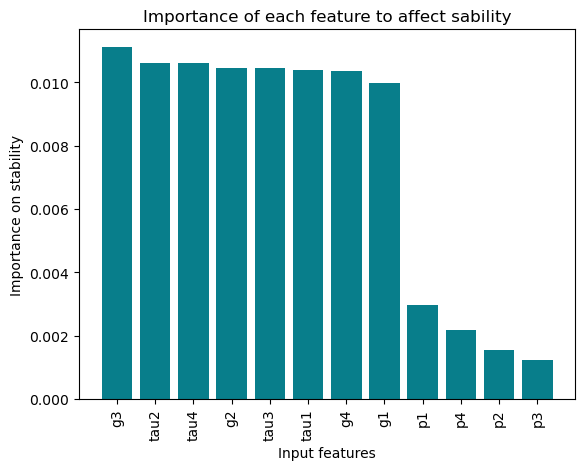

In [186]:
# Feature importance modeling
plt.bar(x=features_importances['Attribute'].iloc[:], height=features_importances['Importance'].iloc[:], color='#087E8B')
plt.title('Importance of each feature to affect sability', size=12)
plt.xticks(rotation='vertical')
plt.xlabel("Input features")
plt.ylabel("Importance on stability")
plt.show()

In [187]:
# Prediction
y_test_pred = pd.DataFrame(model.predict(X_test_scaled),columns = ['stab'] )      # model prediction
y_train_pred =  pd.DataFrame(model.predict(X_train_scaled),columns = ['stab'])

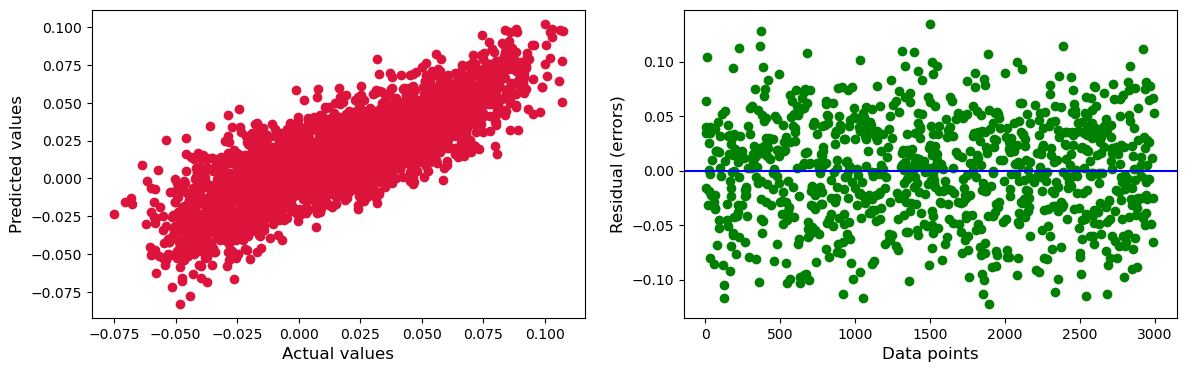

In [188]:
# Prediction versus actual plot

fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].scatter(y_test, y_test_pred, c='crimson')
ax[0].set_xlabel('Actual values', fontsize=12)
ax[0].set_ylabel('Predicted values', fontsize=12)

z = pd.DataFrame(y_test)
e = y_test_pred['stab'] - z['stab']

ax[1].scatter(e.index, e, c='green')
ax[1].set_xlabel('Data points', fontsize=12)
ax[1].set_ylabel('Residual (errors)', fontsize=12)
ax[1].axhline(0, c='b')

In [189]:
print(mse(y_test,y_test_pred))



0.00043264381408033946


In [190]:
R2_test=r2_score(y_test,y_test_pred) # R2 score between the predicted Y test and the actual Y test
R2_train=r2_score(y_train,y_train_pred) # R2 score between the predicted Y train and the actual Y train
print(R2_test) 
print(R2_train)


0.6842057278083746
0.6612142355273941


In [191]:
# Model Evaluation: Adjusted R2
Adj_R2_test= 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1) # len(y_test) = number of samples for the test set, X_test.shape[1] = the number of independent variables for the test set
Adj_R2_train= 1 - (1-R2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(Adj_R2_test) 
print(Adj_R2_train)

0.6829370531293323
0.6606323793410951
